In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

import matplotlib.pyplot as plt
from lib.plotting import adjust_plot_1d

In [41]:
bp = '/home/storage/hans/jax_reco_new/examples/post_conv_mpe/'
MPE_sigma3 = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho2_1st_pulse_postjitter_MPE_tsigma_3.0.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho2_1st_pulse_postjitter_MPE_tsigma_3.0.npy'))])

MPE_sigma3_c = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho2_1st_pulse_postjitter_MPE_tsigma_3.0_clip_charge2.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho2_1st_pulse_postjitter_MPE_tsigma_3.0_clip_charge2.npy'))])

MPE_sigma2_c = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho2_1st_pulse_postjitter_MPE_tsigma_2.0_clip_charge2.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho2_1st_pulse_postjitter_MPE_tsigma_2.0_clip_charge2.npy'))])

In [42]:
bp = '/home/storage/hans/jax_reco_new/examples/'
SPE_sigma2 = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho_1st_pulse_tsigma_2.0.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho_1st_pulse_tsigma_2.0.npy'))])

MPE_sigma2_rho = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho2_1st_pulse_MPE_tsigma_2.0_clip_charge.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho2_1st_pulse_MPE_tsigma_2.0_clip_charge.npy'))])

MPE_sigma2 = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho2_1st_pulse_MPE_tsigma_2.0.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho2_1st_pulse_MPE_tsigma_2.0.npy'))])

In [43]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [44]:
def get_gcd(results):
    scale = 20.0
    reco_zenith, reco_azimuth = results[:, 14]/scale, results[:, 15]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

In [45]:
def get_deltalogl(results):
    muon_energy = results[:, 0]
    delta_logl = results[:, -1]
    return muon_energy, delta_logl

In [46]:
def get_resolution(results):
    gcd, gcd_smpe, muon_energy = get_gcd(results)
       
    def get_quantiles(dpsi, energy, e_bins):
        lower, med, upper = [], [], []
        for el, eh in zip(e_bins[:-1], e_bins[1:]):
            #print(el, eh)
            idx = np.logical_and(energy >= el, energy < eh)
            l, m, u = np.percentile(dpsi[idx], [20, 50, 80])
            lower.append(l)
            med.append(m)
            upper.append(u)
        
        return lower, med, upper

    e_nu_range = [2.0, 6.0]
    e_nu_bins = np.linspace(*e_nu_range, 21)
    centers = lambda x: 0.5 * (x[:-1]+x[1:])
    e_nu_centers = centers(e_nu_bins)
    lower, med, upper = get_quantiles(gcd, np.log10(muon_energy), e_nu_bins)
    lower2, med2, upper2 = get_quantiles(gcd_smpe, np.log10(muon_energy), e_nu_bins)

    return (lower, med, upper), (lower2, med2, upper2), e_nu_centers

In [47]:
r1_MPE3, r2_smpe, xvals = get_resolution(MPE_sigma3)
r1_MPE3_c, r2_smpe, xvals = get_resolution(MPE_sigma3_c)
r1_MPE2_c, r2_smpe, xvals = get_resolution(MPE_sigma2_c)
r1_SPE2, r2_smpe, xvals = get_resolution(SPE_sigma2)
r1_MPE2_2, r2_smpe, xvals = get_resolution(MPE_sigma2_rho)
r1_MPE2, r2_smpe, xvals = get_resolution(MPE_sigma2)

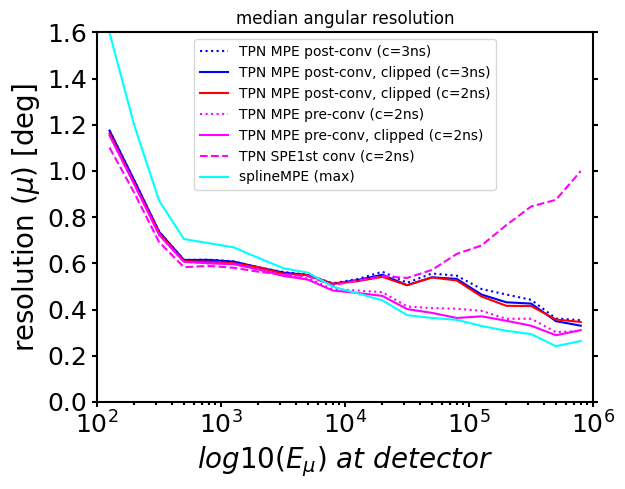

In [48]:
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.0, 1.5]}
    
ax.plot(10**xvals, r1_MPE3[1], color='blue', label='TPN MPE post-conv (c=3ns)', linestyle='dotted')
ax.plot(10**xvals, r1_MPE3_c[1], color='blue', label='TPN MPE post-conv, clipped (c=3ns)')
ax.plot(10**xvals, r1_MPE2_c[1], color='red', label='TPN MPE post-conv, clipped (c=2ns)')
ax.plot(10**xvals, r1_MPE2[1], color='magenta', label='TPN MPE pre-conv (c=2ns)', linestyle='dotted')
ax.plot(10**xvals, r1_MPE2_2[1], color='magenta', label='TPN MPE pre-conv, clipped (c=2ns)')
ax.plot(10**xvals, r1_SPE2[1], color='magenta', label='TPN SPE1st conv (c=2ns)', linestyle='dashed')
ax.plot(10**xvals, r2_smpe[1], color='cyan', label='splineMPE (max)')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.xscale('log')
plt.title('median angular resolution')
ax.set_yticks([0.2*i for i in range(9)])
plt.show()